In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import flatten_dict
import pytorch_lightning as pl
from omegaconf import OmegaConf
import torch

from dabs.src.systems import viewmaker, viewmaker_original


In [2]:
config = OmegaConf.load('/disk2/ofirb/dabs/conf/pretrain_original.yaml')
config.debug = True
config.dataset = OmegaConf.load('/disk2/ofirb/dabs/conf/dataset/cifar10_small.yaml')
config.model = OmegaConf.load('/disk2/ofirb/dabs/conf/model/resnet_small.yaml')

config.dataset.batch_size = 10

pl.seed_everything(config.trainer.seed)

if config.algorithm == 'viewmaker':
    system = viewmaker.ViewmakerSystem(config)
elif config.algorithm == 'original_viewmaker':
    system = viewmaker_original.OriginalViewmakerSystem(config)
elif config.algorithm == 'tama_viewmaker':
    system = viewmaker_original.ViewmakerTAMA38System(config)
system.setup('')
if config.trainer.resume_from_checkpoint:
    system.load_state_dict(torch.load(config.trainer.resume_from_checkpoint)['state_dict'],strict=False)

Global seed set to 0


Files already downloaded and verified
Files already downloaded and verified
50000 train examples, 10000 val examples


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as image
import torchvision
from IPython import display
from viewmaker.src.systems.image_systems.utils import heatmap_of_view_effect
import pylab as pl

%matplotlib inline


In [4]:
loader = system.train_dataloader()
for index , img , labels in loader:
    break

In [36]:
img=image_.unsqueeze(0)


In [37]:
saliency = system.extract_saliency(img).detach().cpu()[0]
normalized_view, view = system.view(img,True)
view_saliency = system.extract_saliency(view).detach().cpu()[0]
view = view.detach().cpu()[0]
img = img[0]

***
# show original images , deltas , and saliencies

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


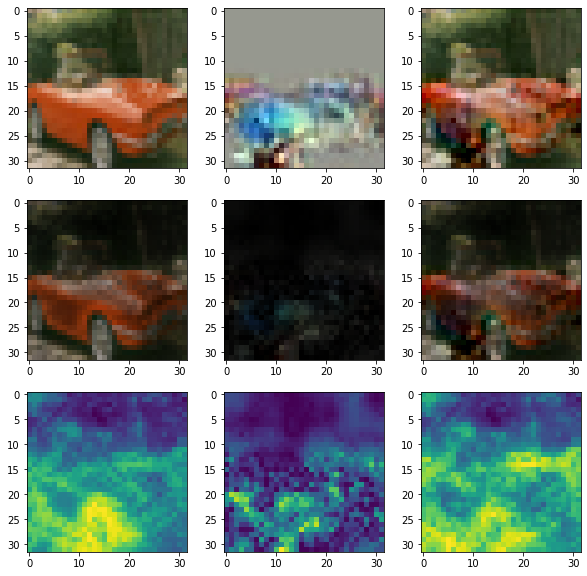

In [38]:

fig = plt.figure(figsize=(10,10))
axs = fig.subplots(3,3)
axs[0,0].imshow(img.permute(1,2,0))
axs[0,1].imshow(heatmap_of_view_effect(img,view).permute(1,2,0))
axs[0,2].imshow(view.permute(1,2,0))
axs[1,0].imshow((img*saliency).permute(1,2,0))
axs[1,1].imshow((heatmap_of_view_effect(img,view)*(saliency-view_saliency).abs()).permute(1,2,0))
axs[1,2].imshow((view*view_saliency).permute(1,2,0))
axs[2,0].imshow(saliency.permute(1,2,0))
axs[2,1].imshow((saliency-view_saliency).abs().permute(1,2,0))
axs[2,2].imshow(view_saliency.permute(1,2,0))

fig.show()

In [32]:
saliency_bars = saliency.histc(bins=100,min=0,max=1)
plt.bar(np.linspace(0,1,100),saliency_bars,width=(1-0)/(100))
plt.show()

NameError: name 'saliency' is not defined

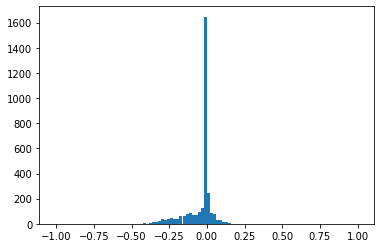

tensor(0.0048)


In [8]:
vm_delta = (view-img)
delta_bars = vm_delta.histc(bins=100,min=-1,max=1)
plt.bar(np.linspace(-1,1,100),delta_bars,width=(1-(-1))/(100))
plt.show()
print(vm_delta[vm_delta>0.025].abs().sum()/vm_delta.numel())

***
## saliency vs viewmaker delta analysis

In [39]:
def saliency_distortion_analysis(saliency,delta,plot=True,axs=None):

    saliency_bars = saliency.histc(bins=100,min=0,max=1)
    saliency_at_delta_bars = saliency[(delta.abs()>0.01).any(0).unsqueeze(0)].histc(bins=100,min=0,max=1)
    saliency_at_delta_bars_b = saliency[(delta[0].abs()>0.01).unsqueeze(0)].histc(bins=100,min=0,max=1)
    saliency_at_delta_bars_g = saliency[(delta[1].abs()>0.01).unsqueeze(0)].histc(bins=100,min=0,max=1)
    saliency_at_delta_bars_r = saliency[(delta[2].abs()>0.01).unsqueeze(0)].histc(bins=100,min=0,max=1)

    fig = plt.figure(figsize=(20,3))
    if axs is None:
        axs = fig.subplots(1,4)
    axs[0].bar(np.linspace(0,1,100),saliency_bars,width=(1-0)/(100),color='black')
    axs[0].bar(np.linspace(0,1,100),saliency_at_delta_bars,width=(1-0)/(100),color='orange')
    # axs[0].bar(np.linspace(0,1,100),saliency_at_delta_bars_r,width=(1-0)/(100),color='red')
    # axs[0].bar(np.linspace(0,1,100),saliency_bars,width=(1-0)/(100),color='black')
    # axs[0].bar(np.linspace(0,1,100),saliency_at_delta_bars_g,width=(1-0)/(100),color='green')
    # axs[0].bar(np.linspace(0,1,100),saliency_bars,width=(1-0)/(100),color='black')
    # axs[0].bar(np.linspace(0,1,100),saliency_at_delta_bars_b,width=(1-0)/(100),color='blue')
    # axs[0].set_xlabel('activated saliencies r')
    # axs[0].set_xlabel('activated saliencies g')
    # axs[0].set_xlabel('activated saliencies b')

    # axs[0].plot(np.linspace(0,1,100),saliency_at_delta_bars_r,color='red')
    # axs[0].plot(np.linspace(0,1,100),saliency_at_delta_bars_g,color='green')
    # axs[0].plot(np.linspace(0,1,100),saliency_at_delta_bars_b,color='blue')
    
    axs[0].twinx().plot(np.linspace(0,1,100),saliency_at_delta_bars/saliency_bars,color='magenta')
    axs[0].set_xlabel('activated saliencies rgb')


    distortion_pdf = []
    avg_distortion_pdf = []
    median_distortion_pdf = []
    total_dist = 0.05
    for x in np.linspace(0,1,100):
        relevant = delta[((saliency>=x)*(saliency<x+((1-0)/100))).expand(3,-1,-1)].view(3,-1).permute(1,0)
        distortion_at_x_saliency = (relevant.abs().sum(dim=0) / delta.numel())
        dist_pcnt = distortion_at_x_saliency / total_dist
        dist_avg = relevant.abs().sum(dim=0) / (relevant.shape[0]+1e-4)
        if relevant.numel()>0:
            dist_median = relevant.abs().median(dim=0)[0]
        else:
            dist_median = dist_avg
        distortion_pdf.append(dist_pcnt)
        avg_distortion_pdf.append(dist_avg)
        median_distortion_pdf.append(dist_median)

    distortion_pdf = torch.cat([dp.unsqueeze(0) for dp in distortion_pdf],dim=0)
    avg_distortion_pdf = torch.cat([adp.unsqueeze(0) for adp in avg_distortion_pdf],dim=0)
    median_distortion_pdf = torch.cat([mdp.unsqueeze(0) for mdp in median_distortion_pdf],dim=0)
    
    axs[1].bar(np.linspace(0,1,100),saliency_at_delta_bars,width=(1-0)/(100),color='orange')
    twin = axs[1].twinx()
    twin.plot(np.linspace(0,1,100),distortion_pdf[:,0],color='blue')
    twin.plot(np.linspace(0,1,100),distortion_pdf[:,1],color='green')
    twin.plot(np.linspace(0,1,100),distortion_pdf[:,2],color='red')
    axs[1].set_xlabel('distortion distribution')


    axs[2].bar(np.linspace(0,1,100),saliency_at_delta_bars,width=(1-0)/(100),color='orange')
    twin2 = axs[2].twinx()
    # twin2.plot(np.linspace(0,1,100),avg_distortion_pdf[:,0],color='blue')
    # twin2.plot(np.linspace(0,1,100),avg_distortion_pdf[:,1],color='green')
    # twin2.plot(np.linspace(0,1,100),avg_distortion_pdf[:,2],color='red')

    twin2.plot(np.linspace(0,1,100),median_distortion_pdf[:,0],color='blue')
    twin2.plot(np.linspace(0,1,100),median_distortion_pdf[:,1],color='green')
    twin2.plot(np.linspace(0,1,100),median_distortion_pdf[:,2],color='red')

    axs[2].set_xlabel('median distortion')

    axs[3].bar(np.linspace(0,1,100),saliency_at_delta_bars,width=(1-0)/(100),color='orange')
    twin3 = axs[3].twinx()
    twin3.plot(np.linspace(0,1,100),distortion_pdf[:,0].cumsum(0),color='blue')
    twin3.plot(np.linspace(0,1,100),distortion_pdf[:,1].cumsum(0),color='green')
    twin3.plot(np.linspace(0,1,100),distortion_pdf[:,2].cumsum(0),color='red')
    axs[3].set_xlabel('distortion cdf')

    if plot:
        fig.show()
    
    return distortion_pdf,avg_distortion_pdf,median_distortion_pdf

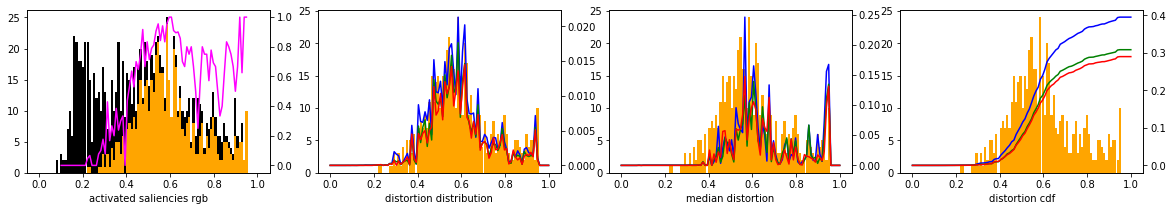

In [10]:

_ = saliency_distortion_analysis(saliency,vm_delta.cpu().detach())

***
## different areas of noise

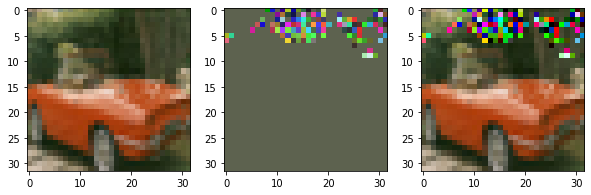

In [11]:
noise = 2*torch.rand_like(img) -1
noise[(saliency>0.2).expand(3,-1,-1)] = 0
avg_dist = noise.abs().mean()
noise = noise * 0.05 / (avg_dist + 1e-4)
undercover_view = (img + noise).clamp(0,1)
fig = plt.figure(figsize=(10,3))
axs = fig.subplots(1,3)
axs[0].imshow(img.permute(1,2,0))
axs[1].imshow(heatmap_of_view_effect(img,undercover_view).permute(1,2,0))
axs[2].imshow(undercover_view.permute(1,2,0))
fig.show()

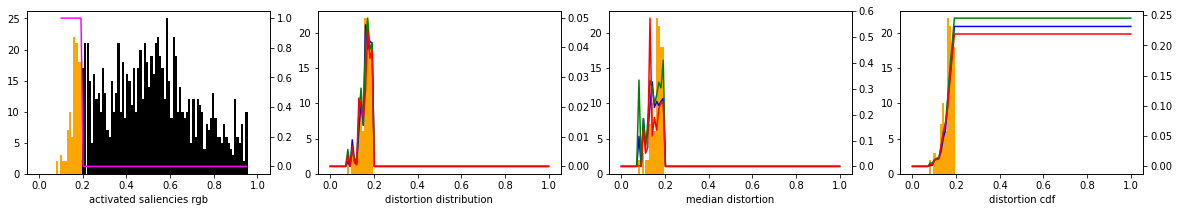

In [12]:
_=saliency_distortion_analysis(saliency,(undercover_view-img))

In [13]:
embds_orig = system.model([system.normalize(img)])[0]
embds_orig = embds_orig / embds_orig.norm()

embds_view = system.model([system.normalize(view)])[0]
embds_view = embds_view / embds_view.norm()

sim_orig_view = embds_orig @ embds_view
print(f'original vs view Similarity: {sim_orig_view:.4f}')


embds_undercover_view = system.model([system.normalize(undercover_view)])[0]
embds_undercover_view = embds_undercover_view / embds_undercover_view.norm()

sim_orig_undercover = embds_orig @ embds_undercover_view
print(f'original vs undercover view Similarity: {sim_orig_undercover:.4f}')

original vs view Similarity: 0.9964
original vs undercover view Similarity: 0.9710


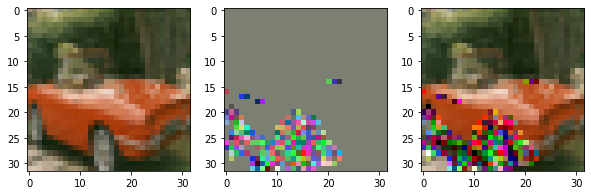

In [14]:
noise_high_saliency = 2*torch.rand_like(img) -1
noise_high_saliency[(saliency<0.7).expand(3,-1,-1)] = 0
avg_dist = noise_high_saliency.abs().mean()
noise_high_saliency = noise_high_saliency * 0.05 / (avg_dist + 1e-4)
high_saliency_view = (img + noise_high_saliency).clamp(0,1)
fig = plt.figure(figsize=(10,3))
axs = fig.subplots(1,3)
axs[0].imshow(img.permute(1,2,0))
axs[1].imshow(heatmap_of_view_effect(img,high_saliency_view).permute(1,2,0))
axs[2].imshow(high_saliency_view.permute(1,2,0))
fig.show()

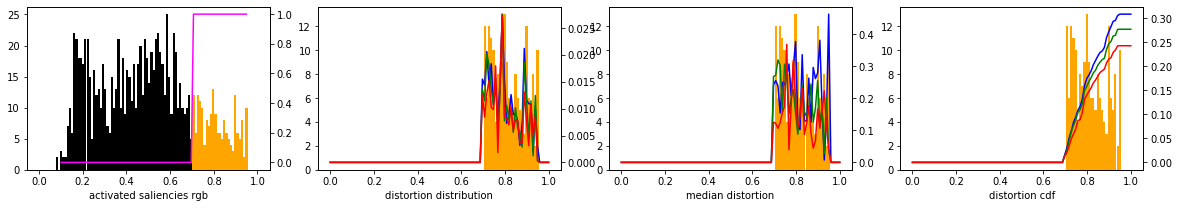

In [15]:
_=saliency_distortion_analysis(saliency,(high_saliency_view-img))

In [16]:
embds_high_saliency_view = system.model([system.normalize(high_saliency_view)])[0]
embds_high_saliency_view = embds_high_saliency_view / embds_high_saliency_view.norm()

sim_orig_high_saliency = embds_orig @ embds_high_saliency_view
print(f'original vs undercover view Similarity: {sim_orig_high_saliency:.4f}')


original vs undercover view Similarity: 0.9772


original vs just noise view Similarity: 0.9950


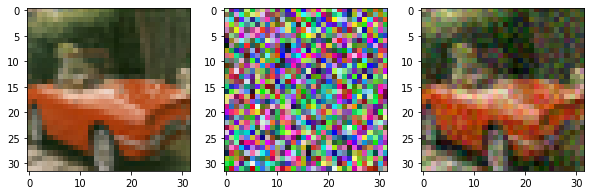

In [17]:
torch.manual_seed(555)
noise = 2*torch.rand_like(img) -1
avg_dist = noise.abs().mean()
just_noise = noise * 0.05 / (avg_dist + 1e-4)
noise_view = (img + just_noise).clamp(0,1)
fig = plt.figure(figsize=(10,3))
axs = fig.subplots(1,3)
axs[0].imshow(img.permute(1,2,0))
axs[1].imshow(heatmap_of_view_effect(img,noise_view).permute(1,2,0))
axs[2].imshow(noise_view.permute(1,2,0))
fig.show()

embds_just_noise_view = system.model([system.normalize(noise_view)])[0]
embds_just_noise_view = embds_just_noise_view / embds_just_noise_view.norm()

sim_orig_just_noise = embds_orig @ embds_just_noise_view
print(f'original vs just noise view Similarity: {sim_orig_just_noise:.4f}')


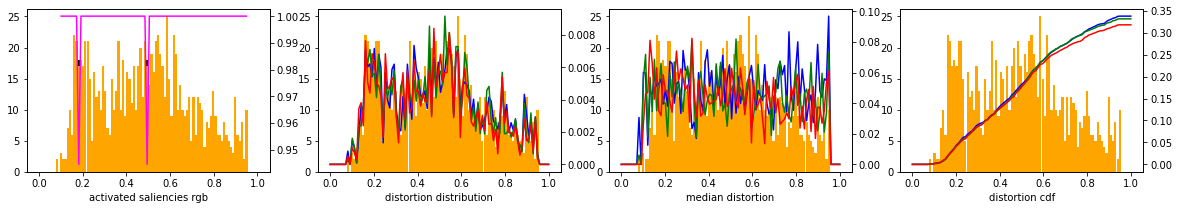

In [18]:
_=saliency_distortion_analysis(saliency,(noise_view-img))

***
## noise optimization analysis

In [46]:

class SimilarityLoss(torch.nn.Module):
    def __init__(self, target,):
        super(SimilarityLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = (self.target/torch.norm(self.target)) @ (input/torch.norm(input))
        return self.loss

def forward(delta,img):
    avg_dist = delta.abs().mean()
    just_delta = delta * 0.05 / (avg_dist + 1e-4)
    _input = (img + just_delta).clamp(0,1)
    _input_embeds = system.model([system.normalize(_input)])[0]
    _input_embeds = _input_embeds / _input_embeds.norm()
    return _input_embeds


def optimize_delta(delta,img):
    similarity = SimilarityLoss(system.model(system.normalize(img)))

    torch.manual_seed(555)
    
    delta.requires_grad_(True)
    system.model.requires_grad_(False)
    optimizer = torch.optim.Adam([delta],lr=2e-4)

    refs = []
    epochs = 1001
    every_epochs = 100
    for epoch in range(epochs):
        # correct the values of updated input image
        optimizer.zero_grad()
        _input_embeds = forward(delta,img)
        loss = similarity(_input_embeds)
        loss.backward()
        
        if epoch % every_epochs == 0:
            display.clear_output(wait=True)

            avg_dist = delta.abs().mean()
            just_delta = delta * 0.05 / (avg_dist + 1e-4)
            _input = (img + just_delta).clamp(0,1)
            img_delta = _input.detach().cpu()

            fig = plt.figure(figsize=(25,6))
            axs = fig.subplots(2,4)
            axs[0][0].imshow(img.permute(1,2,0))
            axs[0][0].set_xlabel('original image')
            axs[0][1].imshow(heatmap_of_view_effect(img,img_delta).permute(1,2,0))
            axs[0][1].set_xlabel('delta heatmap')
            axs[1][0].imshow(img_delta.permute(1,2,0))
            axs[1][0].set_xlabel(f'image + delta : {loss.item():4f} sim')
            axs[1][1].imshow((img_delta-img).abs().permute(1,2,0))
            axs[1][1].set_xlabel('just delta')
            
            distortion_pdf, avg_distortion , median_distortion = saliency_distortion_analysis(saliency,just_delta.cpu().detach(),False,axs=[axs[0][2],axs[0][3],axs[1][2],axs[1][3]])

            if epoch == 0 or   epochs-epoch < every_epochs:
                refs.append((distortion_pdf,avg_distortion,median_distortion))

            display.display(fig)

        optimizer.step()

    return refs


# noise = 2*torch.rand_like(img) -1
# avg_dist = noise.abs().mean()
# random_delta = noise * 0.05 / (avg_dist + 1e-4)

# refs = optimize_delta(random_delta)


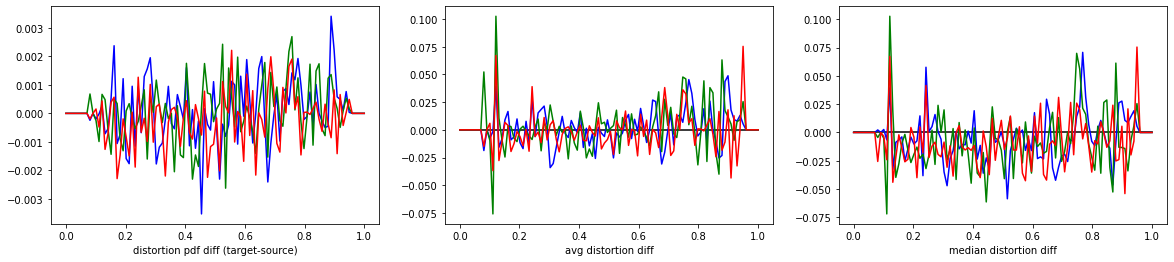

In [20]:
distortion_pdf_diff = refs[1][0]-refs[0][0]
avg_distortion_diff = refs[1][1]-refs[0][1]
median_distortion_diff = refs[1][2]-refs[0][2]

fig = plt.figure(figsize=(20,4))
axs = fig.subplots(1,3)

axs[0].plot(np.linspace(0,1,100),distortion_pdf_diff[:,0],color='blue')
axs[0].plot(np.linspace(0,1,100),distortion_pdf_diff[:,1],color='green')
axs[0].plot(np.linspace(0,1,100),distortion_pdf_diff[:,2],color='red')
axs[0].set_xlabel('distortion pdf diff (target-source)')

axs[1].plot(np.linspace(0,1,100),[0]*100,color='black')
axs[1].plot(np.linspace(0,1,100),avg_distortion_diff[:,0],color='blue')
axs[1].plot(np.linspace(0,1,100),avg_distortion_diff[:,1],color='green')
axs[1].plot(np.linspace(0,1,100),avg_distortion_diff[:,2],color='red')
axs[1].set_xlabel('avg distortion diff')

axs[2].plot(np.linspace(0,1,100),[0]*100,color='black')
axs[2].plot(np.linspace(0,1,100),median_distortion_diff[:,0],color='blue')
axs[2].plot(np.linspace(0,1,100),median_distortion_diff[:,1],color='green')
axs[2].plot(np.linspace(0,1,100),median_distortion_diff[:,2],color='red')
axs[2].set_xlabel('median distortion diff')

fig.show()


In [ ]:
avg_dist = delta.abs().mean()
just_delta = delta * 0.05 / (avg_dist + 1e-4)
_input = (img + just_delta).clamp(0,1)
_input_embeds = system.model([system.normalize(_input)])[0]
_input_embeds = _input_embeds / _input_embeds.norm()

print(f'similarity loss: {(embds_orig @ _input_embeds).item():.5f}')

img_delta = _input.detach().cpu()
fig = plt.figure(figsize=(10,3))
axs = fig.subplots(1,3)
axs[0].imshow(img.permute(1,2,0))
axs[1].imshow((img_delta-img).abs().permute(1,2,0))
axs[2].imshow(img_delta.permute(1,2,0))
fig.show()

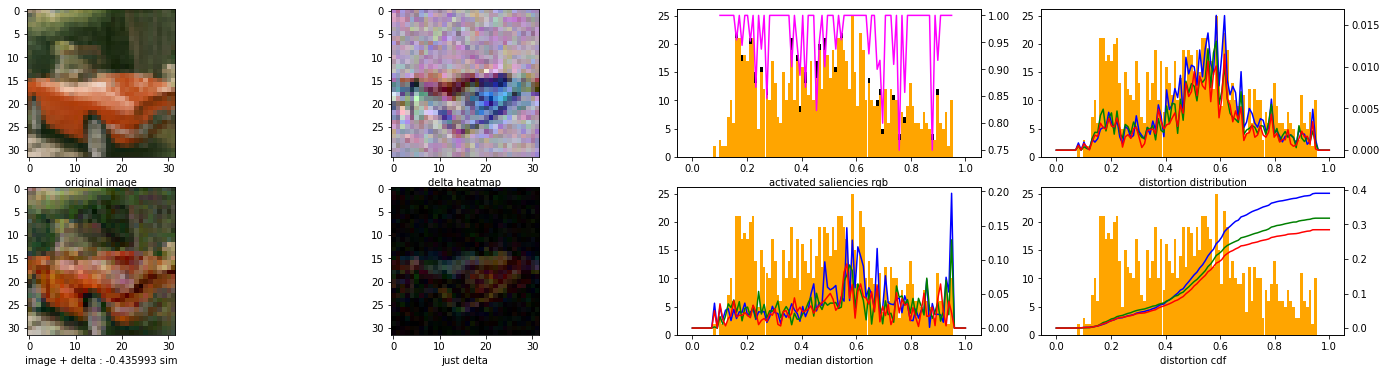

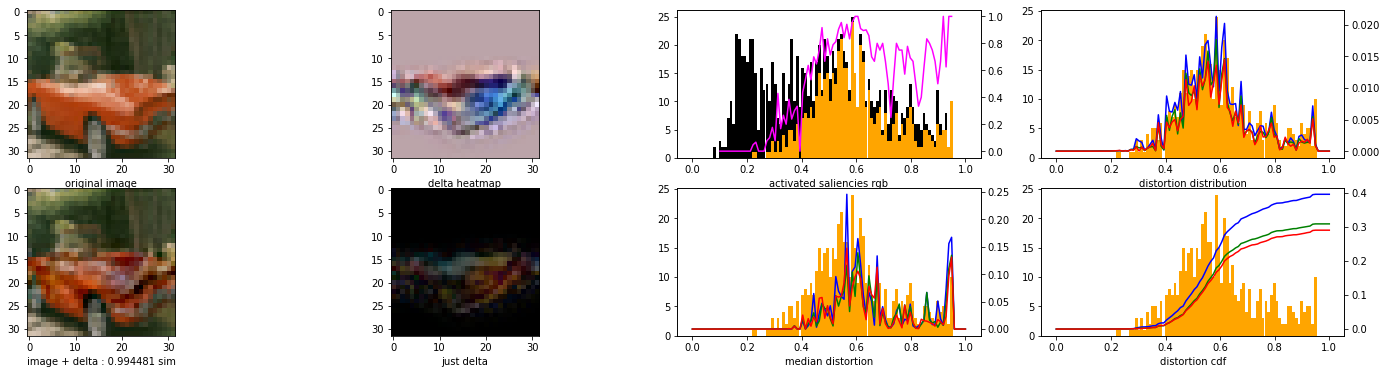

<Figure size 1440x216 with 0 Axes>

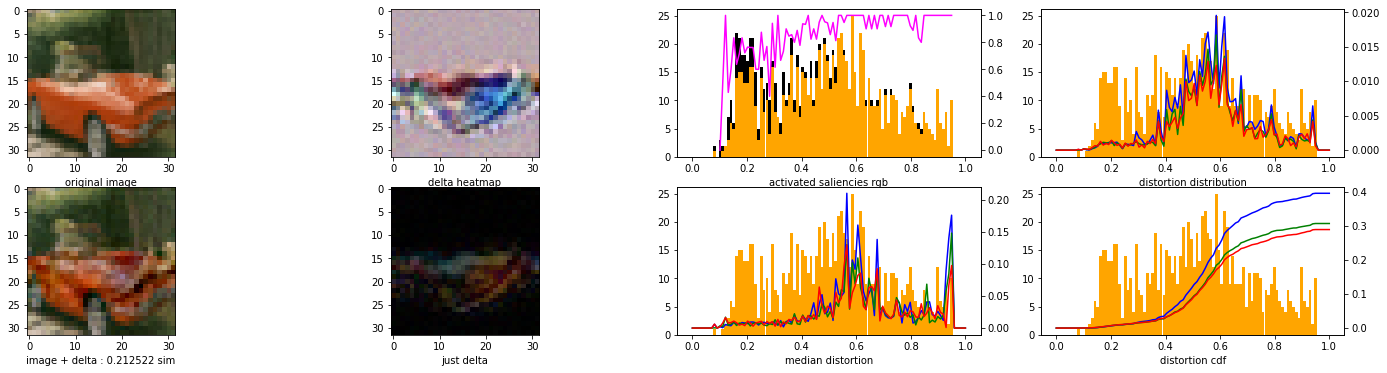

<Figure size 1440x216 with 0 Axes>

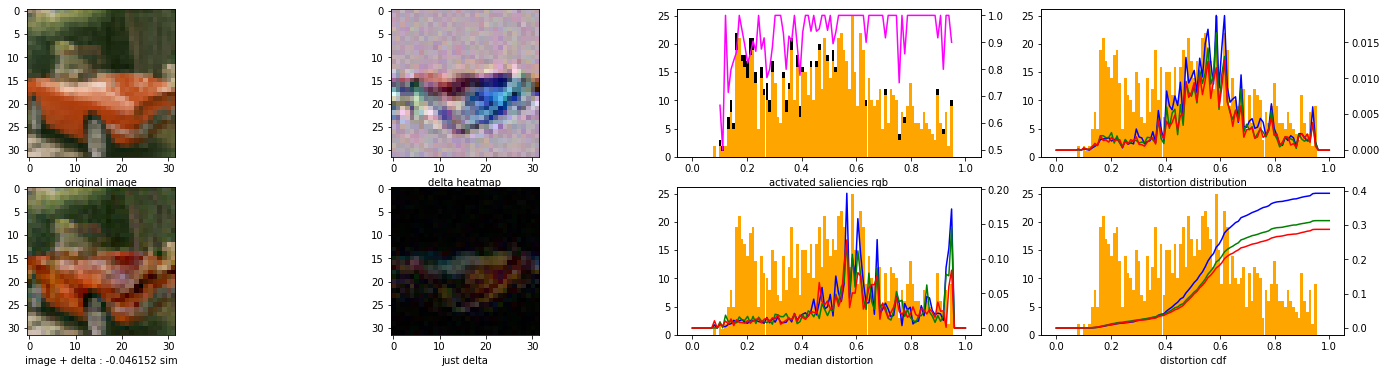

<Figure size 1440x216 with 0 Axes>

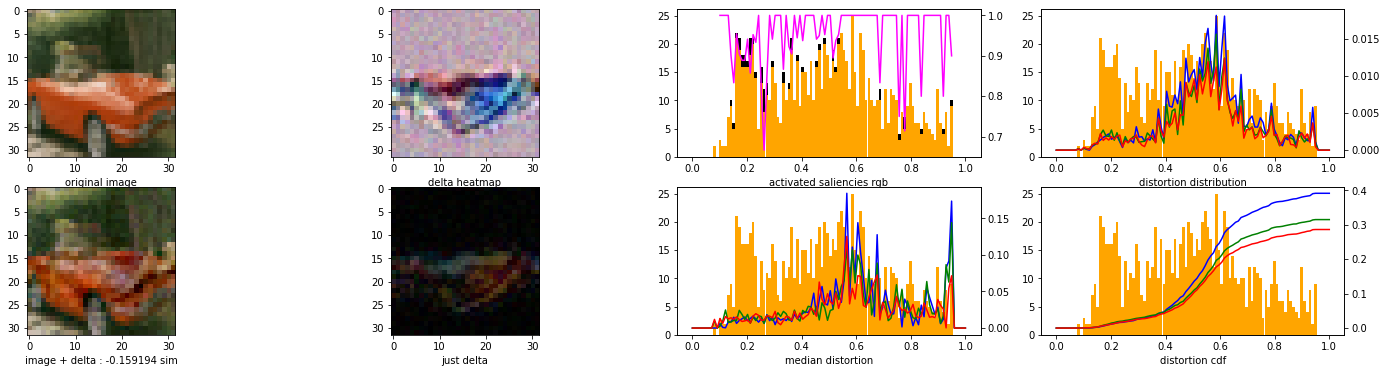

<Figure size 1440x216 with 0 Axes>

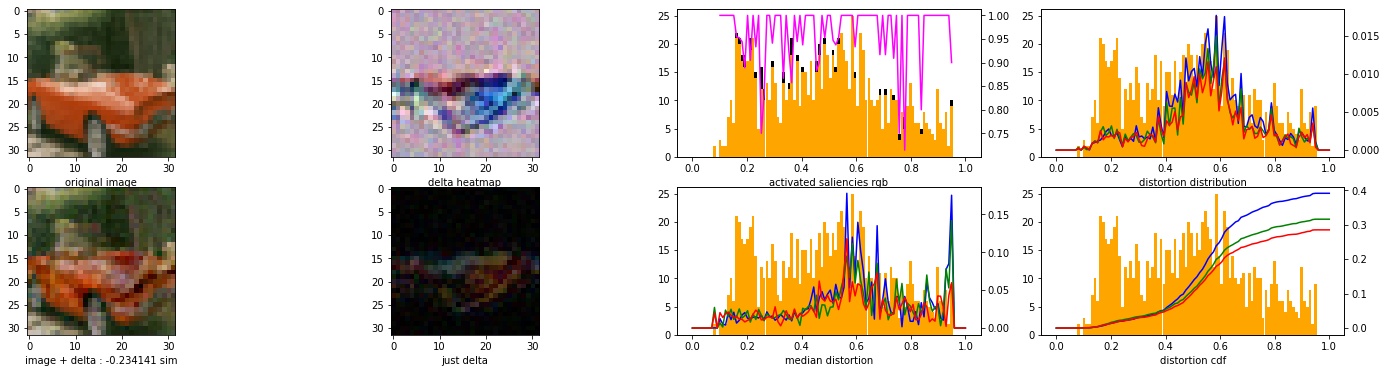

<Figure size 1440x216 with 0 Axes>

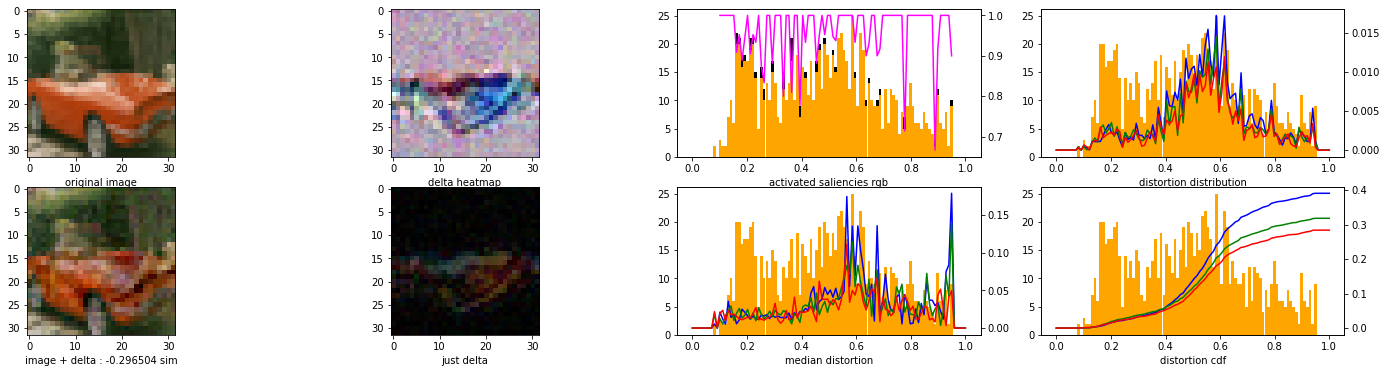

<Figure size 1440x216 with 0 Axes>

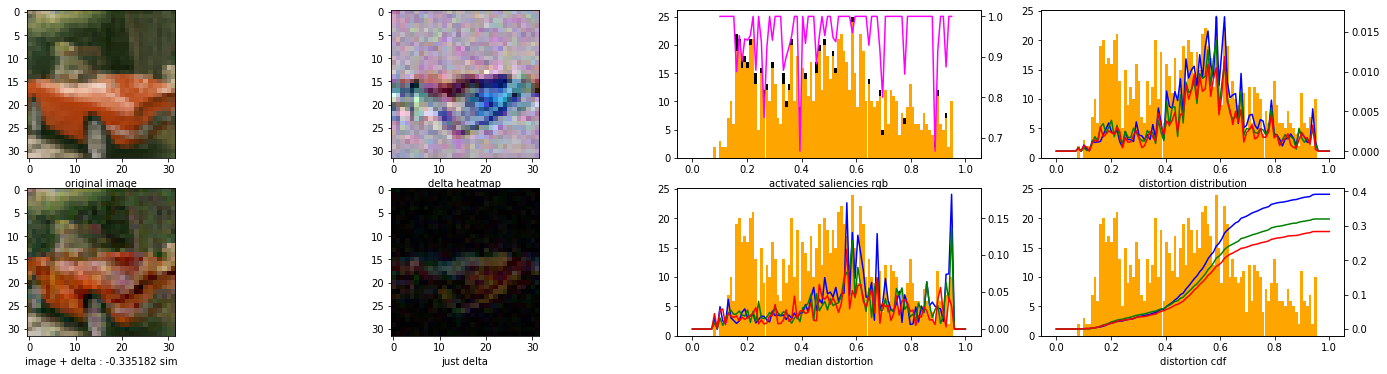

<Figure size 1440x216 with 0 Axes>

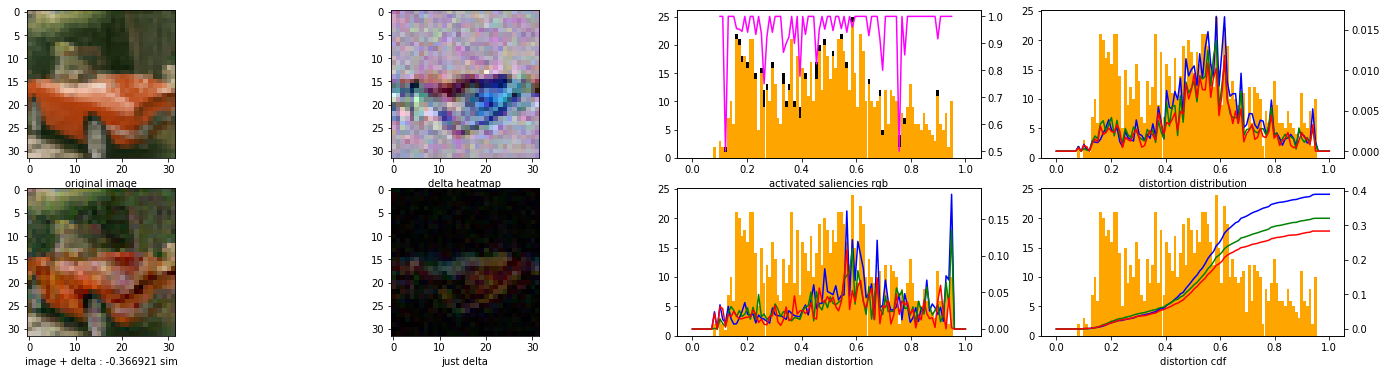

<Figure size 1440x216 with 0 Axes>

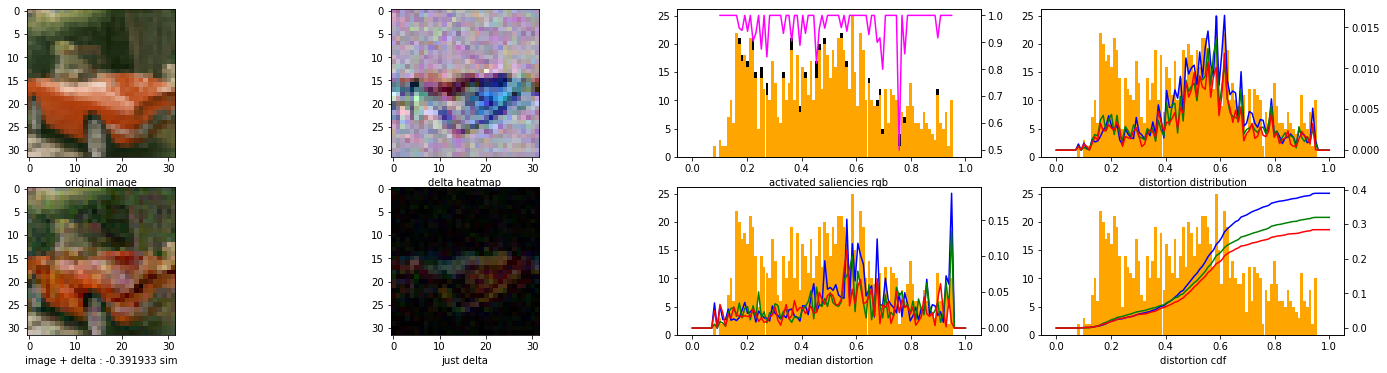

<Figure size 1440x216 with 0 Axes>

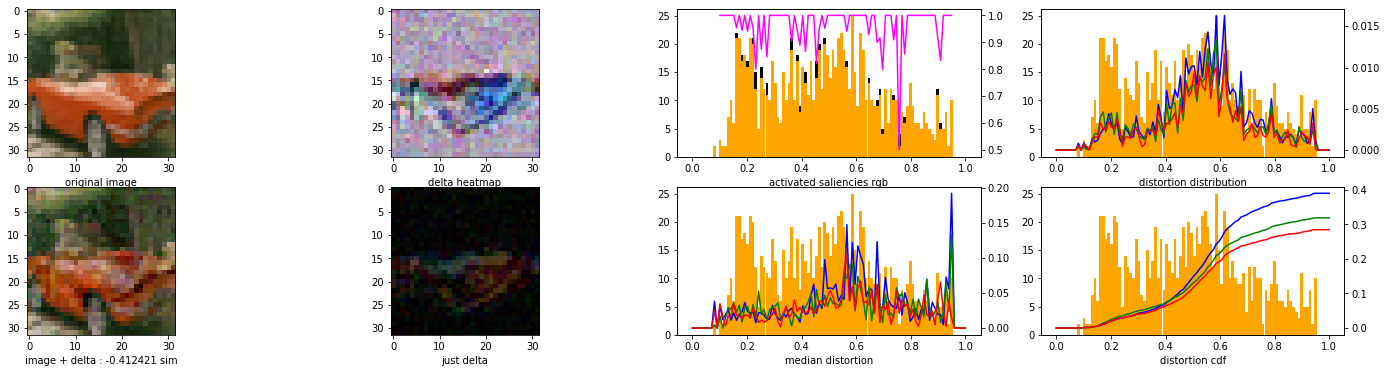

<Figure size 1440x216 with 0 Axes>

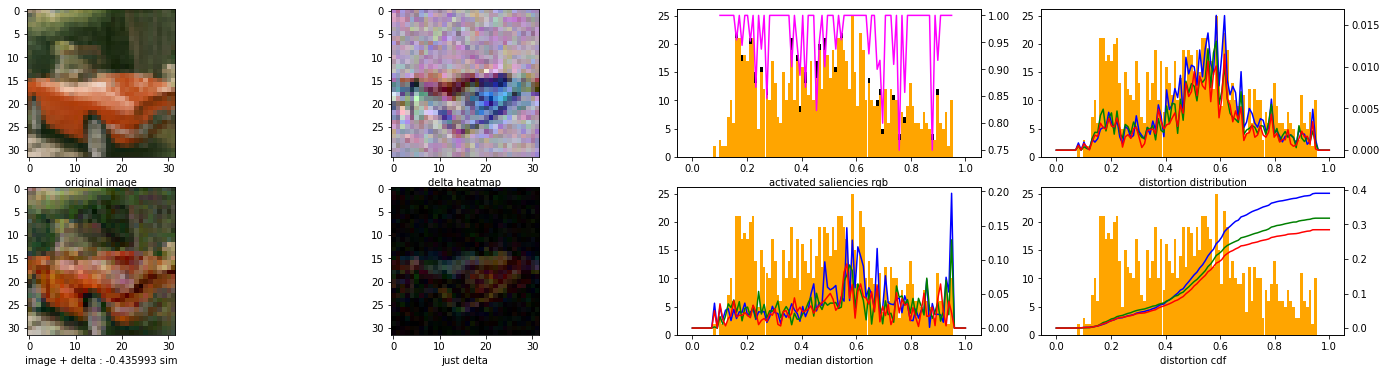

<Figure size 1440x216 with 0 Axes>

In [23]:
vm_refs = optimize_delta(vm_delta.clone())

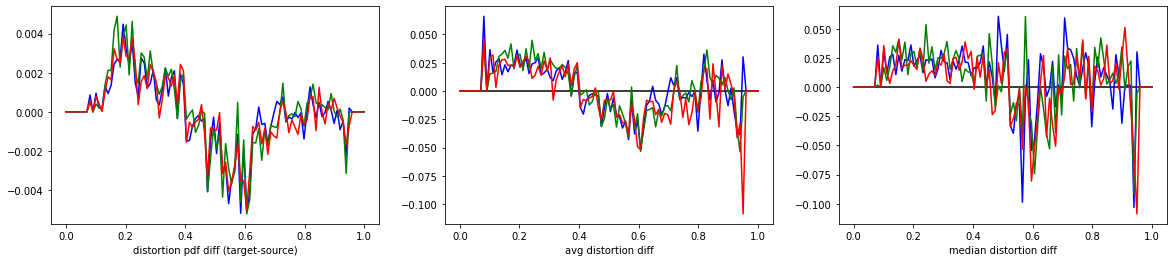

In [24]:
distortion_pdf_diff = vm_refs[1][0]-vm_refs[0][0]
avg_distortion_diff = vm_refs[1][1]-vm_refs[0][1]
median_distortion_diff = vm_refs[1][2]-vm_refs[0][2]

fig = plt.figure(figsize=(20,4))
axs = fig.subplots(1,3)

axs[0].plot(np.linspace(0,1,100),distortion_pdf_diff[:,0],color='blue')
axs[0].plot(np.linspace(0,1,100),distortion_pdf_diff[:,1],color='green')
axs[0].plot(np.linspace(0,1,100),distortion_pdf_diff[:,2],color='red')
axs[0].set_xlabel('distortion pdf diff (target-source)')

axs[1].plot(np.linspace(0,1,100),[0]*100,color='black')
axs[1].plot(np.linspace(0,1,100),avg_distortion_diff[:,0],color='blue')
axs[1].plot(np.linspace(0,1,100),avg_distortion_diff[:,1],color='green')
axs[1].plot(np.linspace(0,1,100),avg_distortion_diff[:,2],color='red')
axs[1].set_xlabel('avg distortion diff')

axs[2].plot(np.linspace(0,1,100),[0]*100,color='black')
axs[2].plot(np.linspace(0,1,100),median_distortion_diff[:,0],color='blue')
axs[2].plot(np.linspace(0,1,100),median_distortion_diff[:,1],color='green')
axs[2].plot(np.linspace(0,1,100),median_distortion_diff[:,2],color='red')
axs[2].set_xlabel('median distortion diff')

fig.show()

### 10.5.2022 todos
- [ ] use different explainability source
- [ ] add constraints to delta optimization ( descriminator / clip?? )
- [x] continue low temp run
- [x] run high temp vm after trained with low temp

In [4]:
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
    LRP,
    visualization
)

In [126]:
system.eval()
loader = system.train_dataloader()
for batch in loader:
    break
    
emb_dict = system.ssl_forward(batch)
encoder_loss, encoder_acc, view_maker_loss, positive_sim, negative_sim = system.objective(emb_dict)
print(encoder_loss,positive_sim,negative_sim)


tensor(-2.0680, grad_fn=<NegBackward>) tensor(0.9726, grad_fn=<MeanBackward0>) tensor(0.2046, grad_fn=<MeanBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


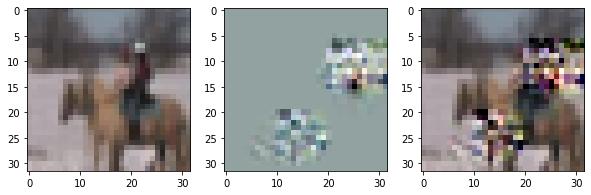

In [127]:
image_ = batch[1]

_, view_ = system.view(image_,True)
view_ = view_.detach().cpu()[0]
image_ = image_[0]

# image_.shape
fig = plt.figure(figsize=(10,3))
axs = fig.subplots(1,3)
axs[0].imshow(image_.permute(1,2,0))
axs[1].imshow(heatmap_of_view_effect(image_,view_).permute(1,2,0))
axs[2].imshow(view_.permute(1,2,0))
fig.show()

In [128]:
from types import MethodType
from copy import deepcopy

def new_forward(self,x):
        x = system.model(x)
        embeds = system.model(system.normalize(image_))
        return (x/torch.norm(x)) @ (embeds/torch.norm(embeds)).permute(1,0)

dummy = deepcopy(system.model)
dummy.forward = MethodType(new_forward,dummy)

# lrp = NoiseTunnel(IntegratedGradients(new_forward))
lrp = LRP(dummy)
# Attribution size matches input size: 3x3x32x32
image_attribution = lrp.attribute(system.normalize(image_.unsqueeze(0)))
view_attribution = lrp.attribute(system.normalize(view_.unsqueeze(0)))

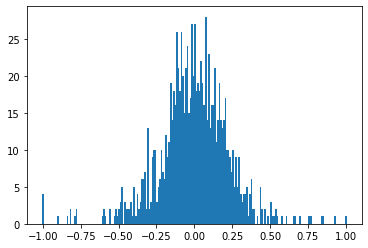

In [75]:
v = visualization._normalize_image_attr(image_attribution.permute(0,2,3,1).detach().numpy()[0],sign='all')
v_bars = np.histogram(v.flatten(),bins=200)
plt.bar(np.linspace(-1,1,200),v_bars[0],width=(1-(-1))/(200))
plt.show()

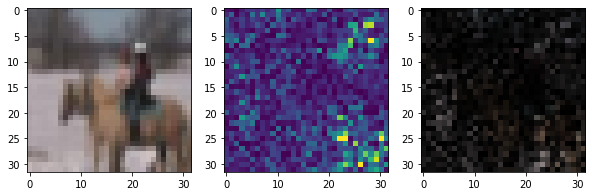

In [129]:
def show_saliency2(img,saliency):
    fig = plt.figure(figsize=(10,10))
    axs = fig.subplots(1,3)
    axs[0].imshow(img.permute(1,2,0))
    axs[1].imshow(np.abs(saliency))
    axs[2].imshow((img*np.abs(saliency)).permute(1,2,0))
    fig.show()

show_saliency2(image_,v)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


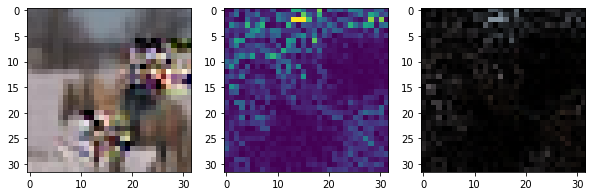

In [130]:
v2 = visualization._normalize_image_attr(view_attribution.permute(0,2,3,1).detach().numpy()[0],sign='all')
show_saliency2(view_,v2)

In [87]:
effective_delta = torch.from_numpy(np.abs(v2-v))*(view_-image_)


In [93]:
print(effective_delta.abs().sum()/effective_delta.numel())
print((view_-image_).abs().sum()/(view_-image_).numel())


tensor(0.0101)
tensor(0.0500)


In [133]:
embds_orig = system.model([system.normalize(image_)])[0]
embds_orig = embds_orig / embds_orig.norm()

embds_view = system.model([system.normalize(view_)])[0]
embds_view = embds_view / embds_view.norm()

sim_orig_view = embds_orig @ embds_view
print(f'original vs view Similarity: {sim_orig_view:.4f}')

original vs view Similarity: 0.9950


In [160]:
from tqdm import tqdm

def calc_expected_similarity(img,saliency,thresh,lower=True,iterations = 1000):
    embds_orig = system.model([system.normalize(img)])[0]
    embds_orig = embds_orig / embds_orig.norm()

    similarities = torch.zeros((iterations,))
    if lower:
        mask = (torch.from_numpy(saliency).abs()>thresh)
    else:
        mask = (torch.from_numpy(saliency).abs()<thresh)

    distorted_pixels_percent =  1 - (mask.sum() / saliency.size)

    for i in tqdm(range(iterations)):
        noise = 2*torch.rand_like(img) -1
        noise[mask.expand(3,-1,-1)] = 0
        avg_dist = noise.abs().mean()
        noise = noise * 0.05 / (avg_dist + 1e-4)
        view = (img + noise).clamp(0,1)
        embds_view = system.model([system.normalize(view)])[0]
        embds_view = embds_view / embds_view.norm()
        similarity = embds_orig @ embds_view
        similarities[i] = similarity

    return similarities.mean(), similarities.std() , distorted_pixels_percent*100


# mean,std = calc_expected_similarity(image_,v,0.4)
# print(mean,std)

In [148]:
# whole image delta
mean,std,distorted_pixels_percent = calc_expected_similarity(image_,v,0.0,iterations=20,lower=False)
print(mean,std,distorted_pixels_percent)

# high saliency delta
mean,std,distorted_pixels_percent = calc_expected_similarity(image_,v,0.5,iterations=20,lower=False)
print(mean,std,distorted_pixels_percent)

# low saliency delta
mean,std,distorted_pixels_percent = calc_expected_similarity(image_,v,0.5,iterations=20,lower=True)
print(mean,std,distorted_pixels_percent)

100%|██████████| 20/20 [00:01<00:00, 17.55it/s]


tensor(0.9511) tensor(0.0180) tensor(1.)


100%|██████████| 20/20 [00:01<00:00, 16.46it/s]


tensor(0.9770) tensor(0.0088) tensor(0.0391)


100%|██████████| 20/20 [00:01<00:00, 16.27it/s]

tensor(0.9525) tensor(0.0129) tensor(0.9609)


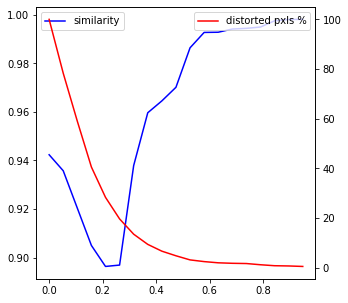

In [175]:
# high saliency delta
z_bin = np.linspace(0, 1,20)
means = []
dist_pctns = []
for i in range(len(z_bin)-1):
    x = z_bin[i]
    mean,std,distorted_pixels_percent = calc_expected_similarity(image_,v,x,iterations=20,lower=False)
    means.append(mean)
    dist_pctns.append(distorted_pixels_percent)
    # print(f'x:{x:.3f}, sim:{mean.item():.3f}, std:{std.item():.3f}, dist_pixels:{distorted_pixels_percent.item():.3f}%')

fig = plt.figure(figsize=(5,5))
axs = fig.subplots(1,1)
axs.plot(z_bin[:-1],means,color='blue',label='similarity')
t = axs.twinx()
t.plot(z_bin[:-1],dist_pctns,color='red',label='distorted pxls %')
t.legend()
axs.legend()
fig.show()

100%|██████████| 20/20 [00:00<00:00, 29.64it/s]


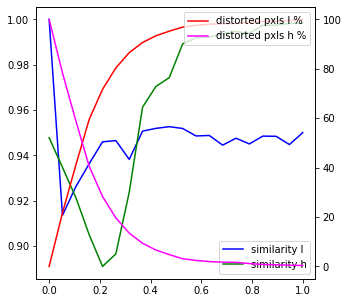

In [180]:
# low saliency delta
z_bin = np.linspace(0, 1,20)
means_l = []
dist_pctns_l = []

means_h = []
dist_pctns_h = []

for i in range(len(z_bin)):
    x = z_bin[i]
    mean,std,distorted_pixels_percent = calc_expected_similarity(image_,v,x,iterations=20,lower=True)
    means_l.append(mean)
    dist_pctns_l.append(distorted_pixels_percent)

    mean,std,distorted_pixels_percent = calc_expected_similarity(image_,v,x,iterations=20,lower=False)
    means_h.append(mean)
    dist_pctns_h.append(distorted_pixels_percent)

fig = plt.figure(figsize=(5,5))
axs = fig.subplots(1,1)
axs.plot(z_bin,means_l,color='blue',label='similarity l')
axs.plot(z_bin,means_h,color='green',label='similarity h')
t = axs.twinx()
t.plot(z_bin,dist_pctns_l,color='red',label='distorted pxls l %')
t.plot(z_bin,dist_pctns_h,color='magenta',label='distorted pxls h %')
t.legend(loc='upper right')
axs.legend(loc='lower right')
fig.show()